---
### Import libraries and features 

In [1]:
import umap
import gc
import sys
import os 
import numpy as np
import pandas as pd 
from pynndescent import NNDescent
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

----
### Import data and split into train and test 

In [4]:
train = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/TrainingData_normal.csv")
dev = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/DevData_normal.csv")
test = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/hold_outset_moreFraud.csv")

In [5]:
training,testing = train_test_dfs(train,dev,test,"Class",0.1,2020)
X_train,y_train = training.drop("Class",axis=1), training.Class
X_test, y_test = testing.drop("Class",axis=1), testing.Class

### garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


----
### Generate simple logistic regression model with default value and original processed features 

In [7]:
lg_1 = LogisticRegression(n_jobs = 20, random_state=20)

In [8]:
lg_1.fit(X_train,y_train)

LogisticRegression(n_jobs=20, random_state=20)

In [9]:
pred_1 = lg_1.predict_proba(X_test)[:,1]

In [10]:
output_1 = model_results(y_test,pred_1,threshold=0.5,ifprint=True)

[[28438     3]
 [   18    22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.88      0.55      0.68        40

    accuracy                           1.00     28481
   macro avg       0.94      0.77      0.84     28481
weighted avg       1.00      1.00      1.00     28481



### Not bad at all for a default try! 
----

### Let's try to use UMAP features and see if it helps or hurts and we will use 15 components 

In [11]:
lg_2 = LogisticRegression(n_jobs = 20, random_state=20)

In [12]:
trans = umap.UMAP(n_neighbors=20, random_state=42,n_components=15).fit(X_train)

In [13]:
train_embed = trans.transform(X_train)
test_embed = trans.transform(X_test)

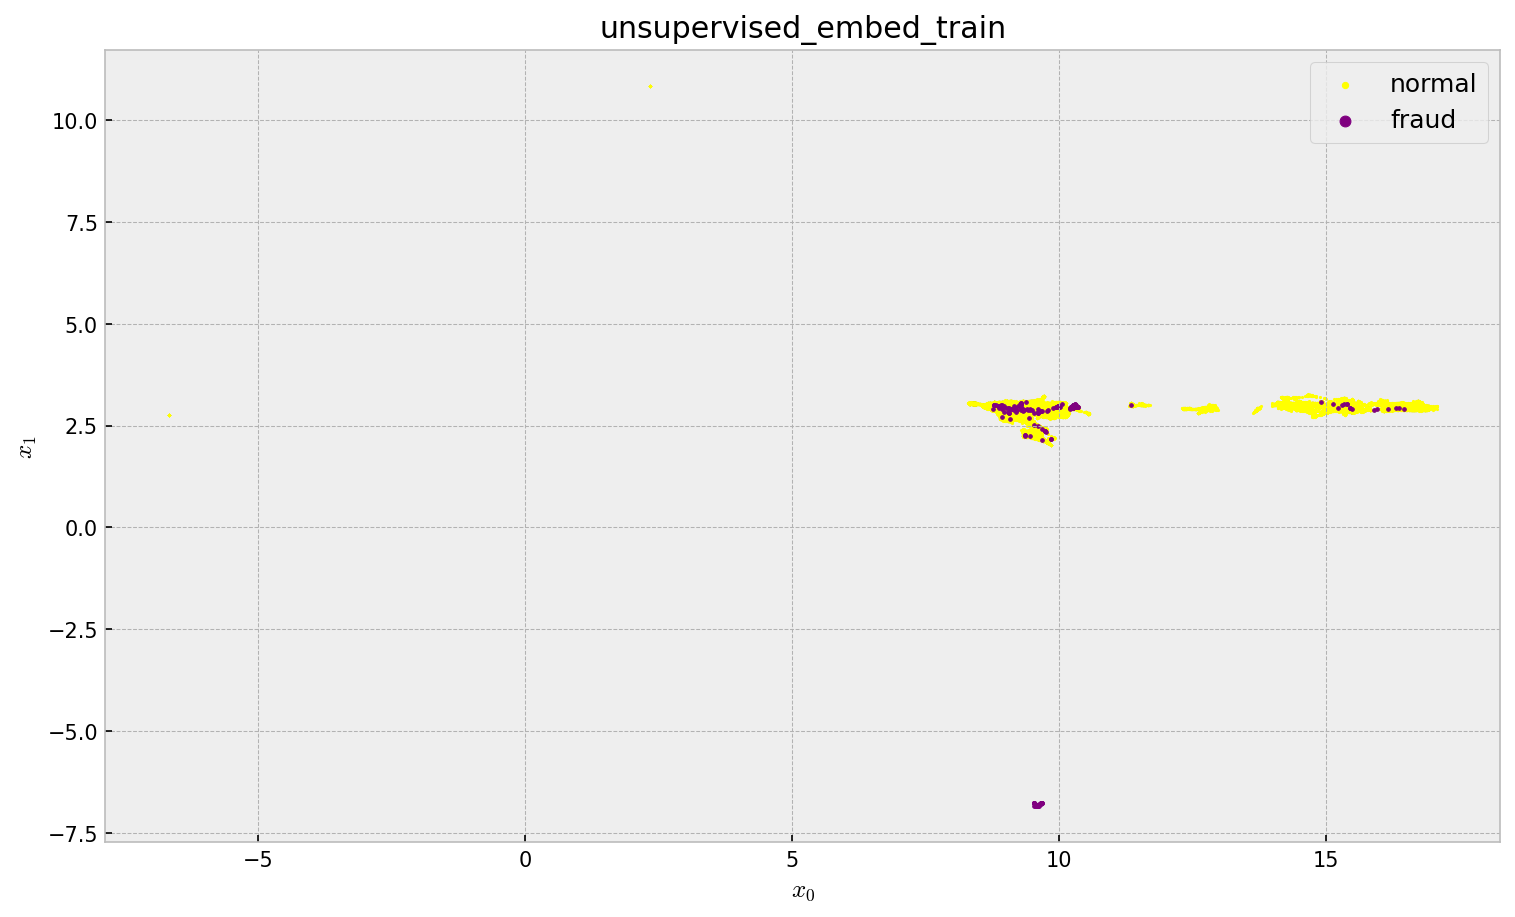

In [14]:
plot_umap(train_embed,"unsupervised_embed_train",y_train)

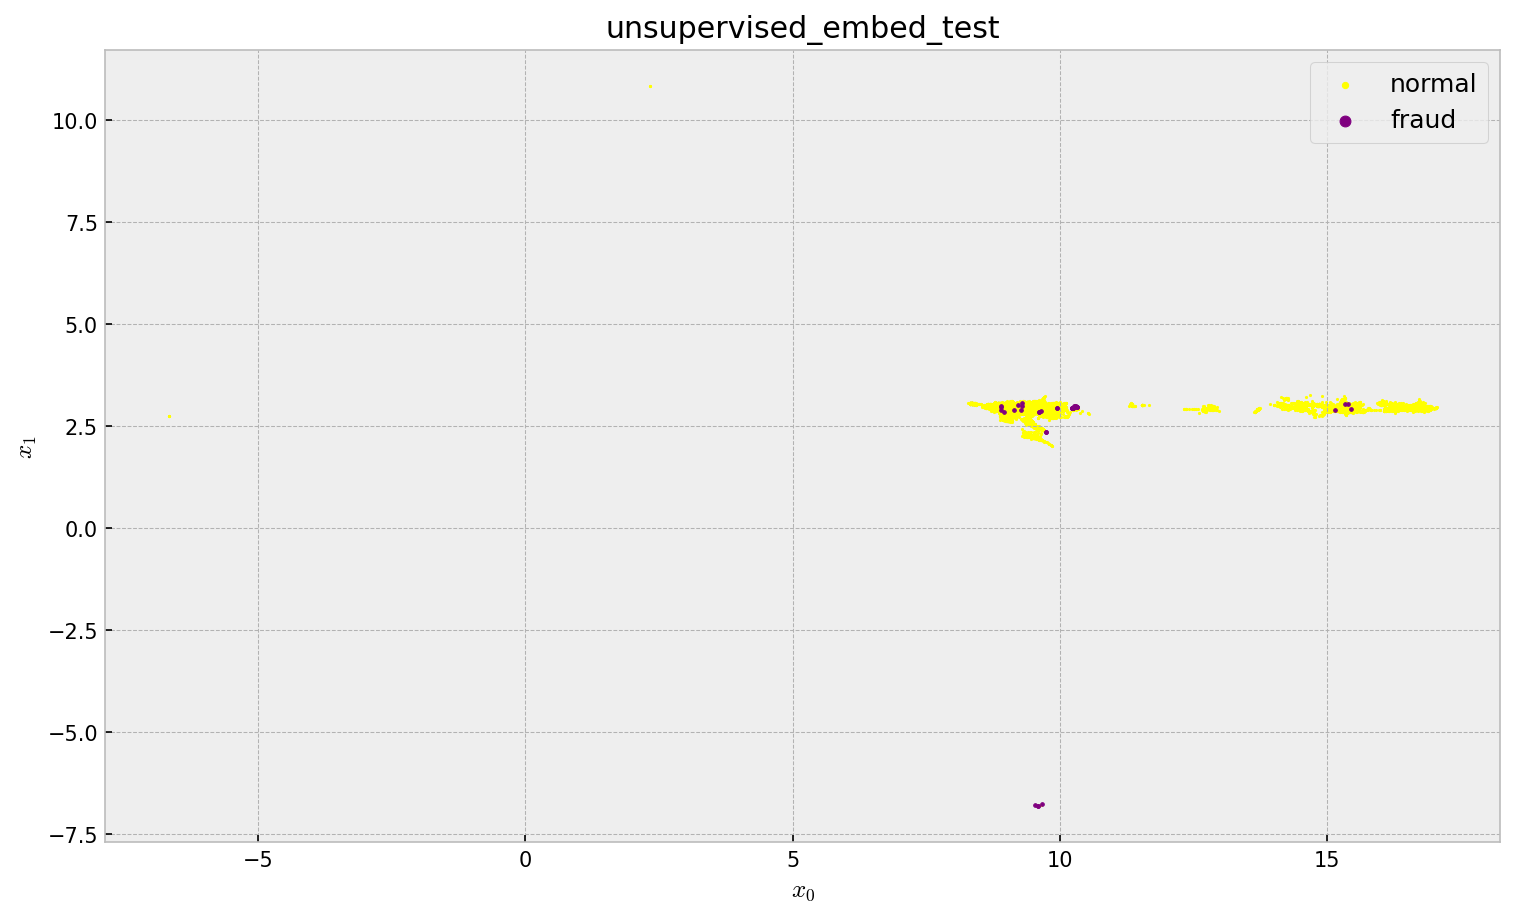

In [15]:
plot_umap(test_embed,"unsupervised_embed_test",y_test)

### You can see some separation between fraud and normal
### garbage collect again

In [20]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


In [21]:
lg_2.fit(train_embed,y_train)

LogisticRegression(n_jobs=20, random_state=20)

In [22]:
pred_2 = lg_2.predict_proba(test_embed)[:,1]

In [23]:
output_2 = model_results(y_test,pred_2,threshold=0.5,ifprint=True)

[[28440     1]
 [   36     4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.80      0.10      0.18        40

    accuracy                           1.00     28481
   macro avg       0.90      0.55      0.59     28481
weighted avg       1.00      1.00      1.00     28481



### It significantly reduced recall power at threshold 0.5 

---
### Let's try the a supervised embedding via an tree model 

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

In [19]:
tree = ExtraTreesClassifier(n_jobs = 20)
tree.fit(X_train,y_train)

ExtraTreesClassifier(n_jobs=20)

In [24]:
output = model_results(y_test,tree.predict_proba(X_test)[:,1],threshold=0.5,ifprint=True)

[[28437     4]
 [   11    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.88      0.72      0.79        40

    accuracy                           1.00     28481
   macro avg       0.94      0.86      0.90     28481
weighted avg       1.00      1.00      1.00     28481



### Very good performance as expected from a tree model 

### Now let's use this info along with UMAP transformation to get 15 components

In [25]:
leaves = tree.apply(X_train)

In [26]:
test_leaves = tree.apply(X_test)

In [27]:
sup_embed_tree = umap.UMAP(metric="hamming",n_components=15).fit(leaves)

In [28]:
train_embed = sup_embed_tree.transform(leaves)
test_embed = sup_embed_tree.transform(test_leaves)

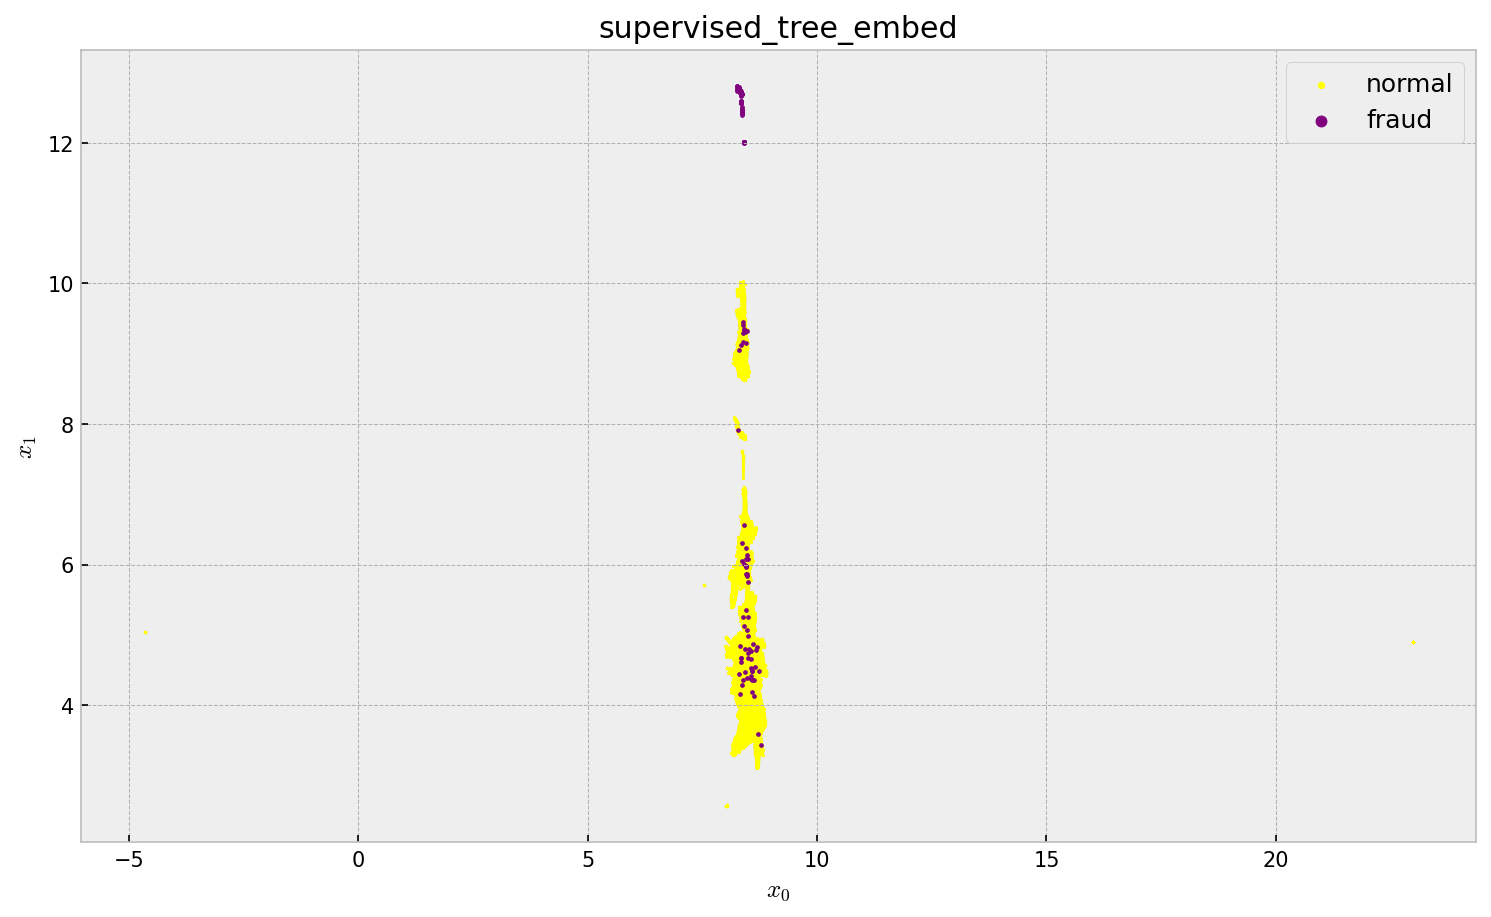

In [29]:
plot_umap(train_embed,"supervised_tree_embed",y_train)

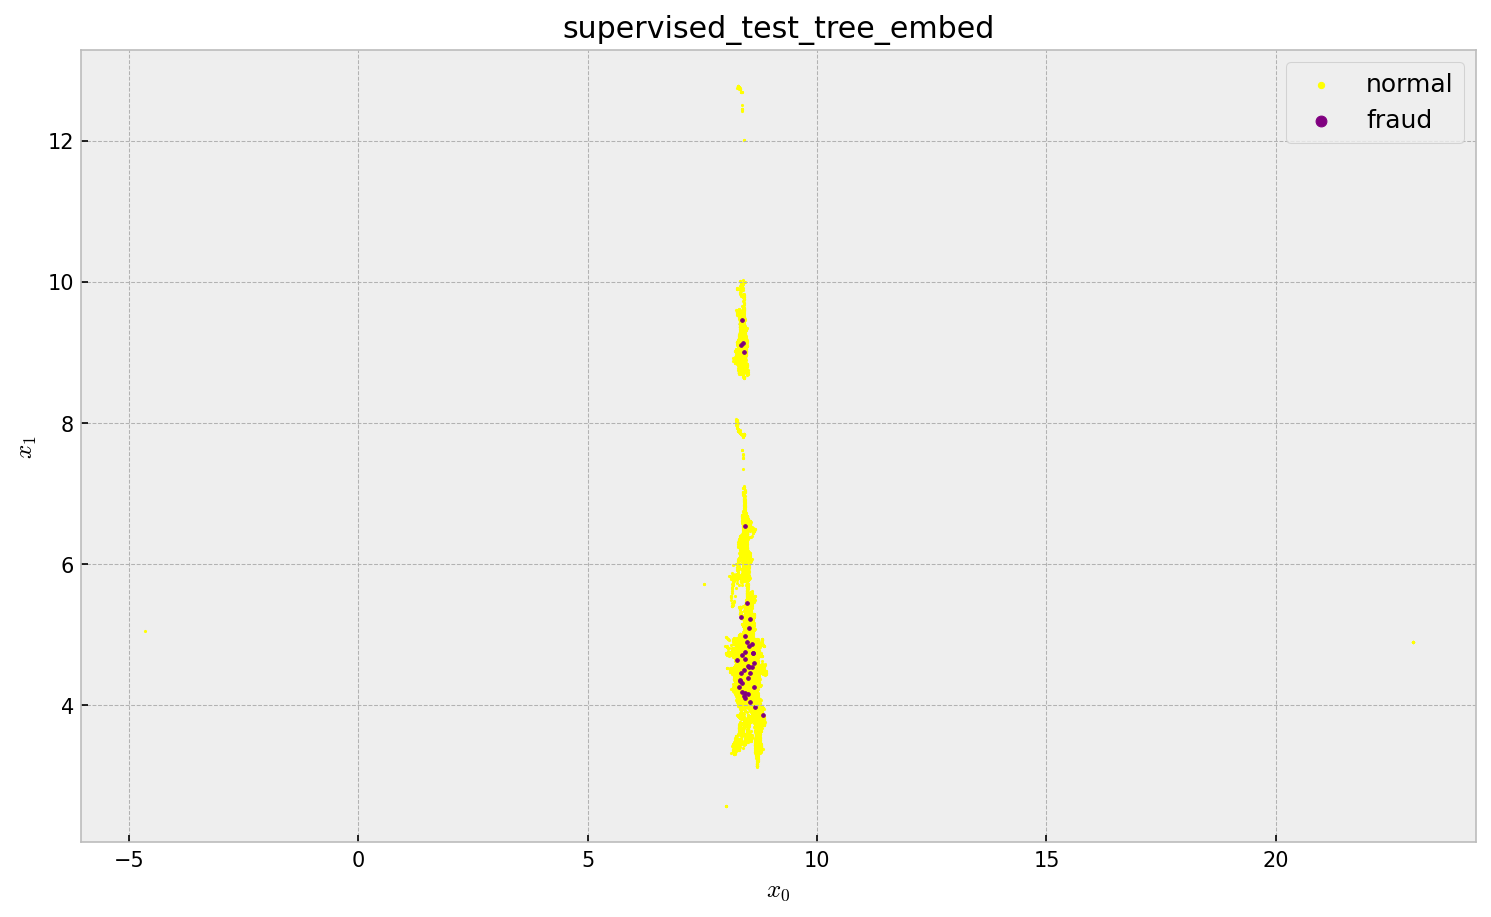

In [30]:
plot_umap(train_embed,"supervised_test_tree_embed",y_test)

### Garbage collect gain 

In [31]:
gc.collect()
%reset -f out 

Flushing output cache (1 entries)


In [32]:
lg_3 = LogisticRegression(n_jobs = 20, random_state=20)

In [34]:
lg_3.fit(train_embed,y_train)

LogisticRegression(n_jobs=20, random_state=20)

In [35]:
pred_3 = lg_3.predict_proba(test_embed)[:,1]

In [36]:
output_3 = model_results(y_test,pred_3,threshold=0.5,ifprint=True)

[[28437     4]
 [   13    27]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.87      0.68      0.76        40

    accuracy                           1.00     28481
   macro avg       0.94      0.84      0.88     28481
weighted avg       1.00      1.00      1.00     28481



### With supervised tree leaves embedding, we will able to improve the lg performance with only half of the features. 

----